<a href="https://colab.research.google.com/github/agustring/imageprocessing/blob/main/PDI%2BML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDI+ML

Automatic building rooftop detection with morphological operations

In [23]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


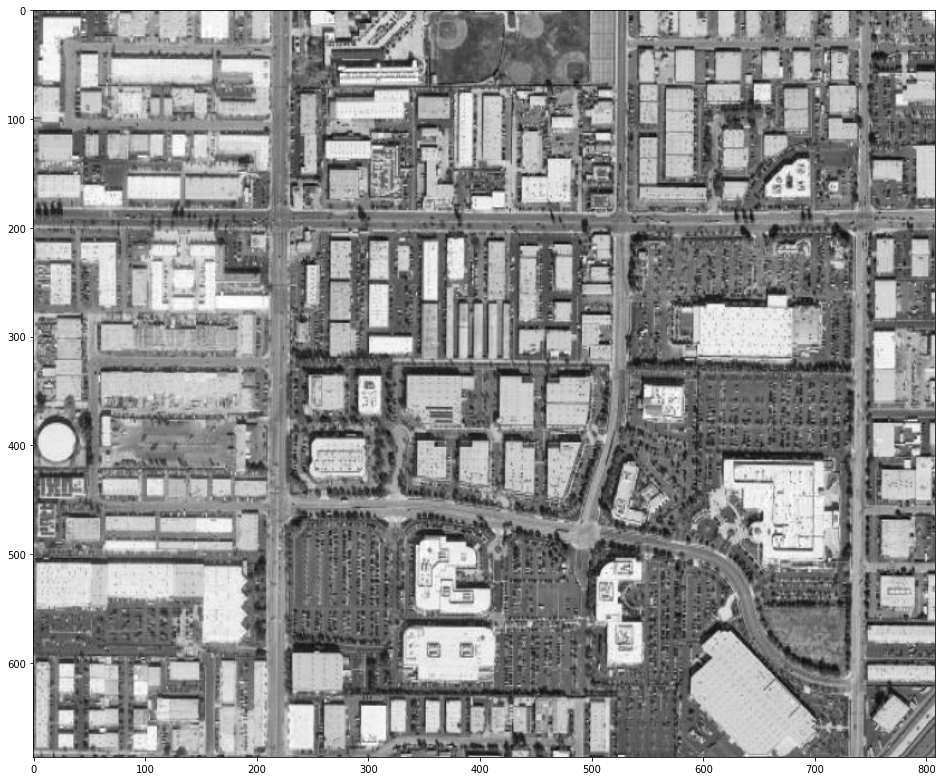

In [24]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/gdrive/MyDrive/Olympic Park.jpg")  
input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (img.shape[1]/50,img.shape[0]/50))
plt.imshow(input_image,'gray',aspect='auto')

Determination of bright and dark regions of the image using White Top-Hat and Black Top-Hat transformation. Then apply enhancement by `I + Iwt - IBt`

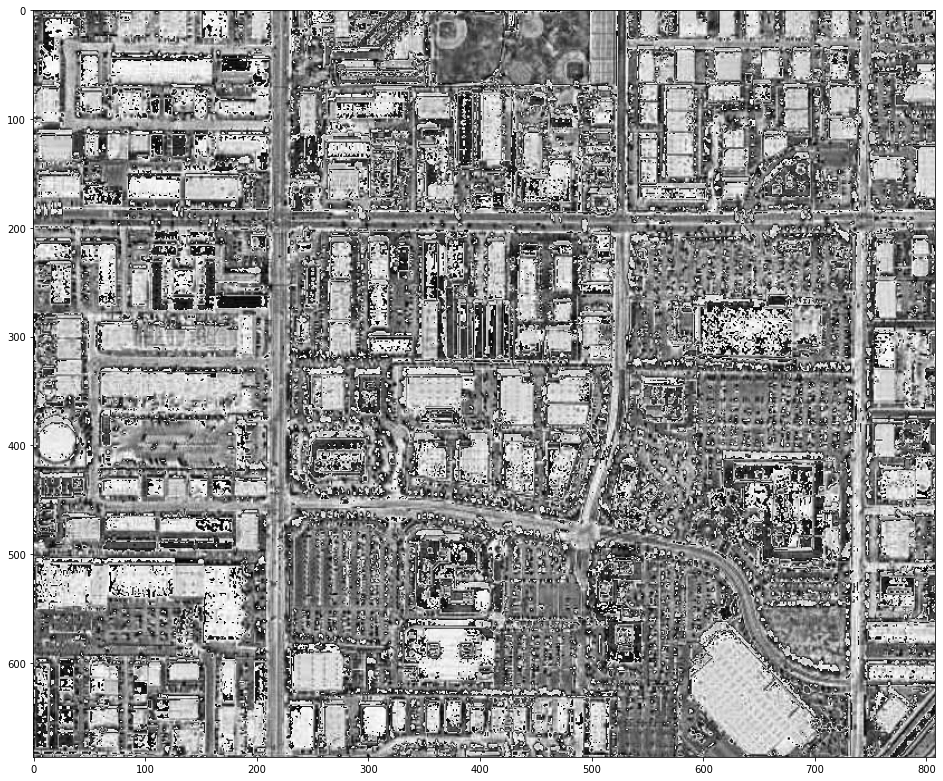

In [25]:
# Getting the kernel to be used in Top-Hat
filterSize =(12,12)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,filterSize)

# Applying the Top-Hat operation
tophat_img = cv2.morphologyEx(input_image,cv2.MORPH_TOPHAT,kernel)

# Applying the Black-Hat operation
blackhat_img = cv2.morphologyEx(input_image,cv2.MORPH_BLACKHAT,kernel)

X = input_image + tophat_img - blackhat_img

plt.figure(figsize = (X.shape[1]/50,X.shape[0]/50))
plt.imshow(X,'gray',aspect='auto')

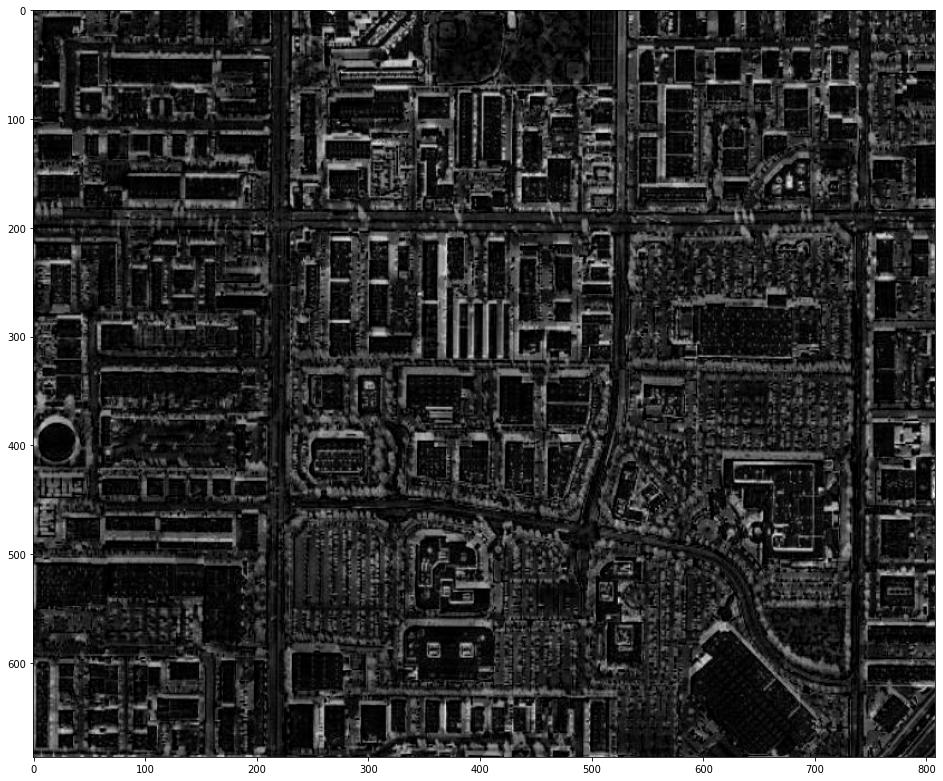

In [26]:
plt.figure(figsize = (X.shape[1]/50,X.shape[0]/50))
plt.imshow(blackhat_img,'gray',aspect='auto')

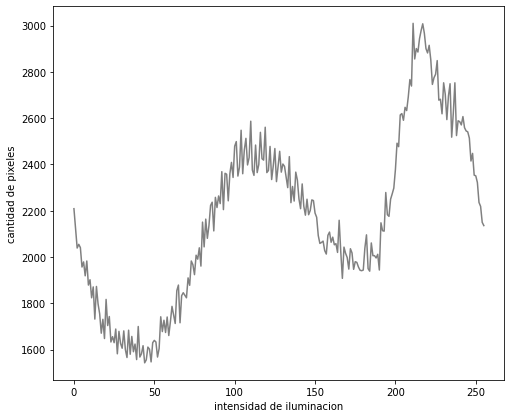

In [27]:
hist = cv2.calcHist([X], [0], None, [256], [0, 256])
plt.figure(figsize = (X.shape[1]/100,X.shape[0]/100))
plt.plot(hist, color='gray' )
plt.xlabel('intensidad de iluminacion')
plt.ylabel('cantidad de pixeles')
plt.show()

Pixel intensity centroid adjusted with K-means.

In [28]:
import numpy as np

Tb=25
Ti=120
Td=191

data = np.empty((X.shape[0]*X.shape[1],2))
i=0

for x in range(X.shape[0]):
    for y in range(X.shape[1]):
        data[i,0] = X[x,y]
        if (X[x,y]<Tb):
            data[i,1]=Tb #Bright
        elif (X[x,y]>Td):
            data[i,1]=Ti #Dark
        else:
            data[i,1]=Td #Intermediate
        i+=1

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

clusters = KMeans(3)
clusters.fit(data[:,0].reshape(-1, 1),data[:,1])

centroides_km = clusters.cluster_centers_
labels_km = clusters.labels_

print(centroides_km)

[[ 41.69417797]
 [214.43105538]
 [125.48621043]]


## Imagen separation
Since here, there's going to be 2 images to work with, Img_dark and Img_bright



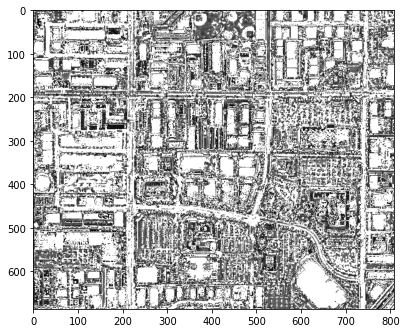

In [29]:
Img_dark = np.empty_like(X)
Img_dark[:,:] = 255

mid = np.median(centroides_km)

for x in range(X.shape[0]):
    for y in range(X.shape[1]):
      if X[x,y] < mid:
          Img_dark[x,y] = X[x,y] 


plt.figure(figsize = (Img_dark.shape[1]/125,Img_dark.shape[0]/125))
plt.imshow(Img_dark,'gray',aspect='auto')

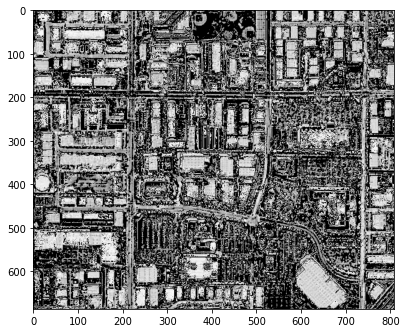

In [30]:
Img_bright = np.empty_like(X)
Img_bright[:,:] = 0

for x in range(X.shape[0]):
    for y in range(X.shape[1]):
      if X[x,y] > mid:
          Img_bright[x,y] = X[x,y] 


plt.figure(figsize = (Img_bright.shape[1]/125,Img_bright.shape[0]/125))
plt.imshow(Img_bright,'gray',aspect='auto')

Filter declaration

Median filter source: https://github.com/MeteHanC/Python-Median-Filter/blob/master/MedianFilter.py

Connected Component Labeling method source: https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

In [31]:
from skimage import data
from skimage.filters import threshold_otsu

def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

## Median filter

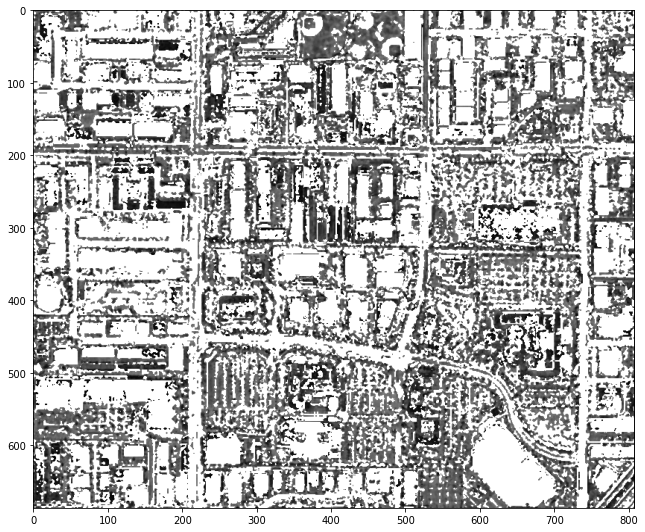

In [32]:
Img_dark = median_filter(Img_dark, 3)
plt.figure(figsize = (Img_dark.shape[1]/75,Img_dark.shape[0]/75))
plt.imshow(Img_dark,'gray',aspect='auto')   

In [33]:
Img_bright = median_filter(Img_bright, 3)
plt.figure(figsize = (Img_bright.shape[1]/75,Img_bright.shape[0]/75))
plt.imshow(Img_bright,'gray',aspect='auto')  

## Otsu Threshold

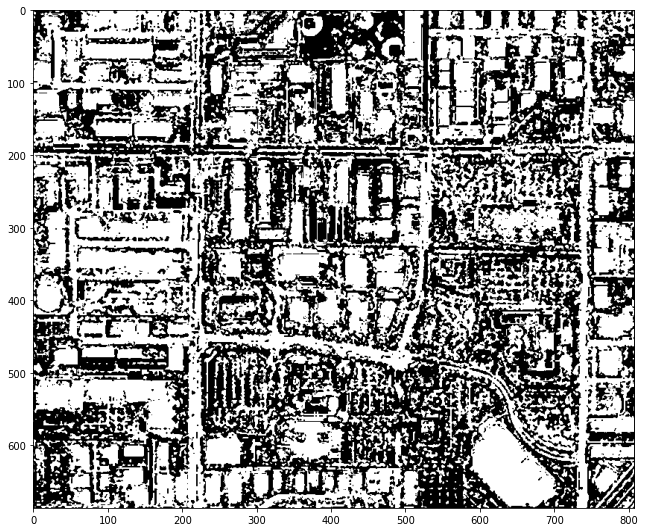

In [34]:
thresh = threshold_otsu(Img_dark)
Img_dark = Img_dark > thresh

plt.figure(figsize = (Img_dark.shape[1]/75,Img_dark.shape[0]/75))
plt.imshow((Img_dark),'gray',aspect='auto')

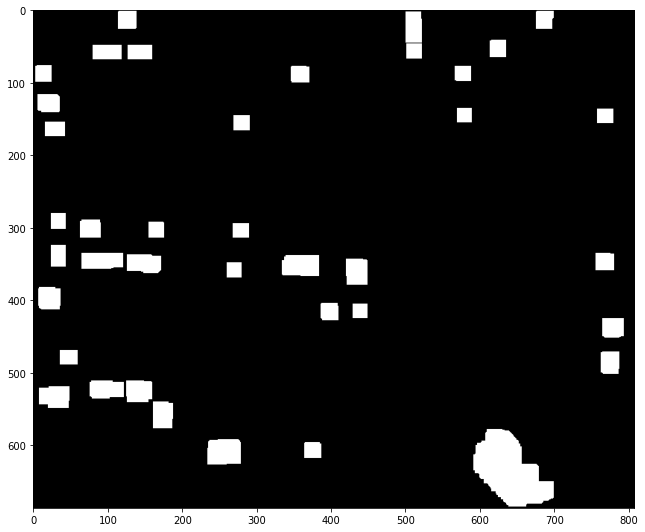

In [35]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
Img_dark = cv2.morphologyEx(np.uint8(Img_dark), cv2.MORPH_OPEN, kernel)

plt.figure(figsize = (Img_dark.shape[1]/75,Img_dark.shape[0]/75))
plt.imshow((Img_dark),'gray',aspect='auto')

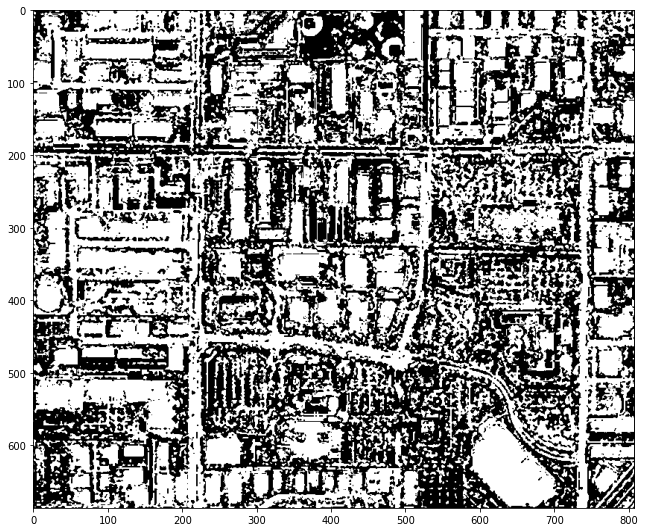

In [36]:
thresh = threshold_otsu(Img_bright)
Img_bright = Img_bright > thresh

plt.figure(figsize = (Img_bright.shape[1]/75,Img_bright.shape[0]/75))
plt.imshow(Img_bright,'gray',aspect='auto')

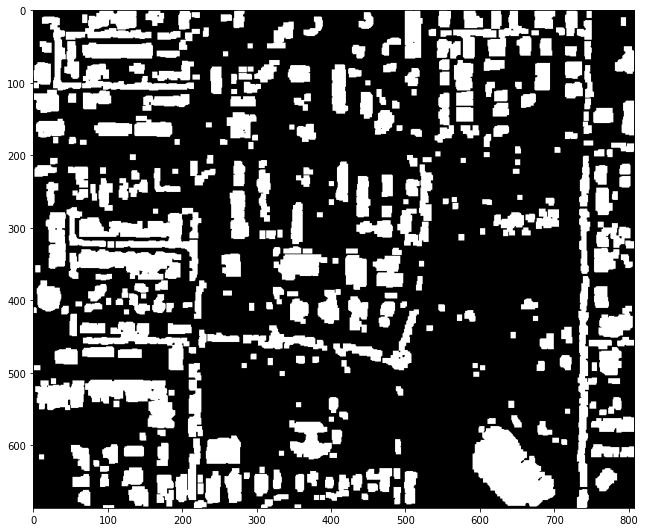

In [37]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
Img_bright = cv2.morphologyEx(np.uint8(Img_bright), cv2.MORPH_OPEN, kernel)

plt.figure(figsize = (Img_bright.shape[1]/75,Img_bright.shape[0]/75))
plt.imshow((Img_bright),'gray',aspect='auto')

## Connected Component Labeling

`num_labels`: The total number of unique labels (i.e., number of total components) that were detected

`labels`: A mask named `labels` has the same spatial dimensions as our input thresh image. For each location in `labels`, we have an integer ID value that corresponds to the connected component where the pixel belongs. You’ll learn how to filter the `labels` matrix later in this section.

`stats`: Statistics on each connected component, including the bounding box coordinates and area (in pixels).

`centroids`: The centroids (i.e., center) (x, y)-coordinates of each connected component.

https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

In [38]:
def visualize_stats(num_labels, labels, stats, centroids):
  # loop over the number of unique connected component labels
  x = np.zeros(num_labels)
  y = np.zeros(num_labels)
  w = np.zeros(num_labels)
  h = np.zeros(num_labels)
  area = np.zeros(num_labels)
  index = []
  for i in range(0, num_labels):

    delta = 3
    centro = 7
    ww = stats[i, cv2.CC_STAT_WIDTH]
    hh = stats[i, cv2.CC_STAT_HEIGHT]
    if hh > 4 and ww > 4:
        if ww > hh:
            sar = ww/hh
        else:
            sar = hh/ww
    if not(sar > centro+delta or sar < centro-delta):
        x[i] = 0
        y[i] = 0
        w[i] = 0
        h[i] = 0
        area[i] = 0
        (cX, cY) = 0,0
    else:    
        #cv2.rectangle(mask,pt1=(x,y),pt2=(x+w,y+h),color=(255,0,0),thickness= 1)
        x[i] = stats[i, cv2.CC_STAT_LEFT]
        y[i] = stats[i, cv2.CC_STAT_TOP]
        w[i] = stats[i, cv2.CC_STAT_WIDTH]
        h[i] = stats[i, cv2.CC_STAT_HEIGHT]
        area[i] = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        index.append(i)
  return x, y, w, h, area, index

def imshow_components(labels, index): #Components visualize
    # Map component labels to hue val
    #x=0
    #for i in range(labels.shape[0]-1):
     # for j in range(labels.shape[1]-1):
      #  if not(labels[i][j] in index):
       #   labels[i][j] = 0
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    #print(label_hue)
    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    #cv2.imshow('labeled.png', labeled_img)
    plt.figure(figsize = (labeled_img.shape[1]/50,labeled_img.shape[0]/50))
    plt.imshow(labeled_img,'gray',aspect='auto')  
    return np.array(labeled_img)

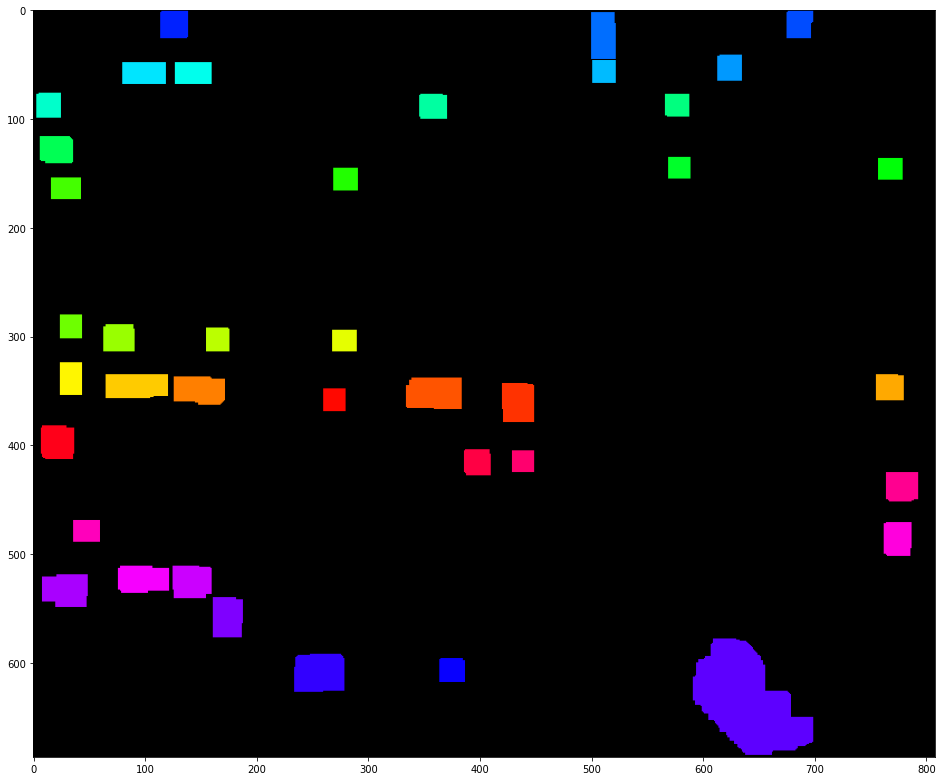

In [39]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(Img_dark),8)
x, y, w, h, area, index = visualize_stats(num_labels, labels, stats, centroids)

labeled_img = imshow_components(labels,index)

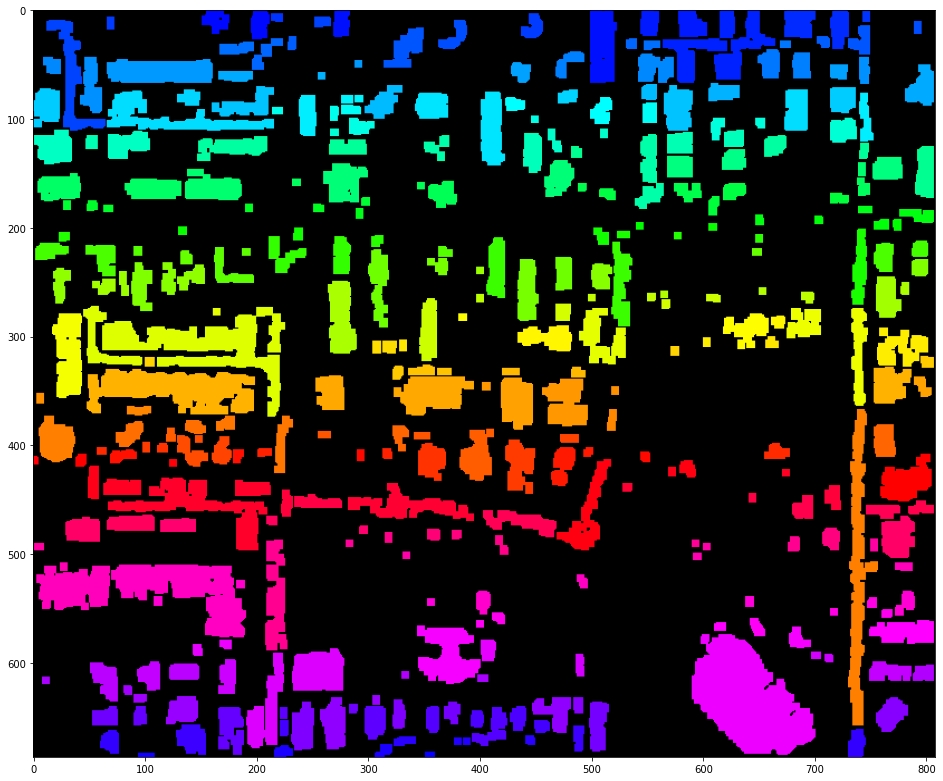

In [40]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(Img_bright),8)
x, y, w, h, area, index = visualize_stats(num_labels, labels, stats, centroids)

labeled_img2 = imshow_components(labels,index)

Finalmente se puede destacar el comportamiento de estos filtros al modificar el tamaño de su
elemento estructural, dejando como optimo el filtro de 15x15, que, si bien no llega a detectar tantos
edificios, es decir, es alto el nivel de falsos negativos, no es tanta la deficiencia como el de falsospositivos del filtro 10x10. 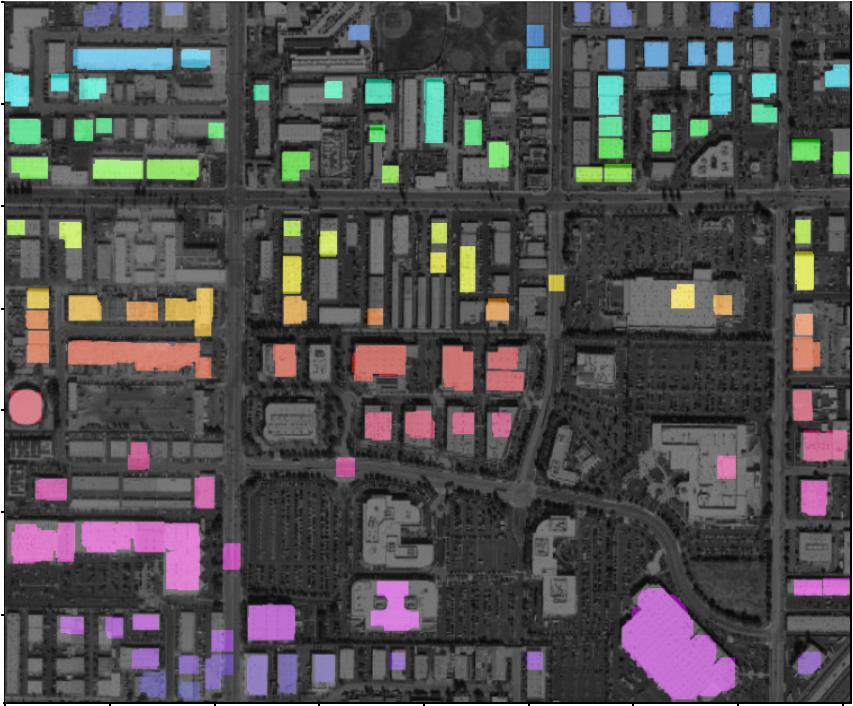




En la imagen solo se muestra el resultado para 15x15, pueden verse el resto de los resultados y todos los procedimientos detallados en el documento: https://drive.google.com/file/d/1ynFhqaJ2iL8B3TBVma21xrvzdXrkgMYJ/view?usp=sharing

Todos estos procedimientos nos hacen darnos cuenta de todas las herramientas que nos provee
el mundo del procesamiento digital de imágenes para los diferentes campos de la vida, es de sumo
interés continuar investigando distintas temáticas que contribuyan al avance tecnológico de la
humanidad y construir nuestro futuro a partir de estos.